# Python Code from Derivatives to Backpropagation

Source: https://shahaliyev.org//writings/backprop

The following material was initially prepared as a lecture for CSCI 4701: Deep Learning (Spring 2025) course at ADA University. The notebook is mainly based on [Andrej Karpathy's lecture on Micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=6309s).

We will go from illustrating differentiation and finding derivatives in Python, all the way down till the implementation of the backpropagation algorithm.

### Table of Contents
- Differentiation
- Partial Derivatives
- Micrograd and Computation Graph
- Gradient
- Chain Rule
- Optimization with Gradient Descent
- Forward pass
- Backward Pass
- Training Model with Backpropagation
- PyTorch Implementation

## Differentiation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return x**2

In [3]:
x = 3.0
for h in [10, 1, 0.1, 0]:
  print(f"If we shift input by {h}, output becomes {f(x+h)}")

If we shift input by 10, output becomes 169.0
If we shift input by 1, output becomes 16.0
If we shift input by 0.1, output becomes 9.610000000000001
If we shift input by 0, output becomes 9.0


In [4]:
h = 1.0

dx = h
dy = f(x+h) - f(x)

print(f"Δx: {dx}")
print(f"Δy: {dy}")
print(f"When you change x by {dx} unit, y changes by {dy} units.")

Δx: 1.0
Δy: 7.0
When you change x by 1.0 unit, y changes by 7.0 units.


In [5]:
def plot_delta(x, h, start=-4, stop=4, num=30):
  # `np.linspace` returns an array of num inputs within a range.
  x_all = np.linspace(start, stop, num)
  y_all = f(x_all)

  plt.figure(figsize=(4, 4))
  plt.plot(x_all, y_all)

  # dx & dy
  plt.plot([x, x + h], [f(x), f(x)], color='r')
  plt.plot([x + h, x + h], [f(x), f(x + h)], color='r')

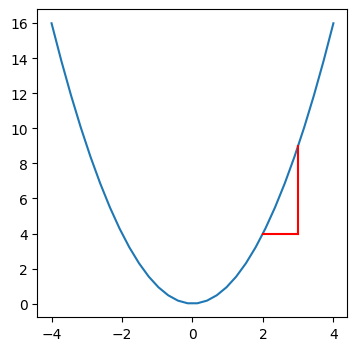

In [6]:
plot_delta(x=2, h=1)

How to find if the ouput changes significantly when we change the input by some amount h?

In [7]:
def plot_roc(x, h):
  dx = h
  dy = f(x + h) - f(x)

  plot_delta(x, h)
  print(f"Rate of change is {dy / dx}")

Rate of change is 7.0


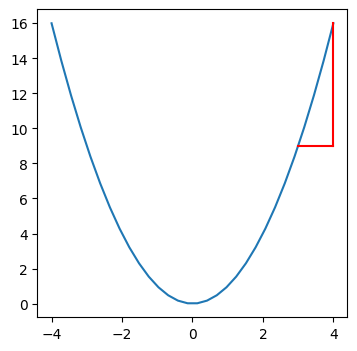

In [8]:
plot_roc(3, 1)

Rate of change is 6.5


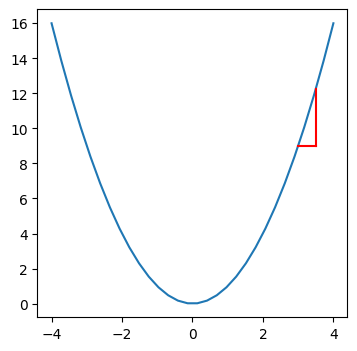

In [9]:
plot_roc(3, 0.5)

Rate of change is 3.0


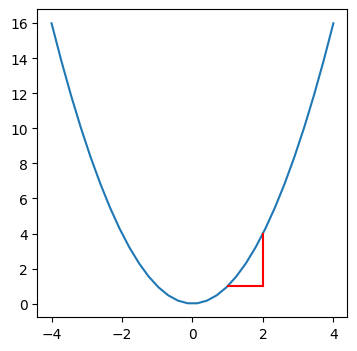

In [10]:
plot_roc(1, 1)

Rate of change is -3.5


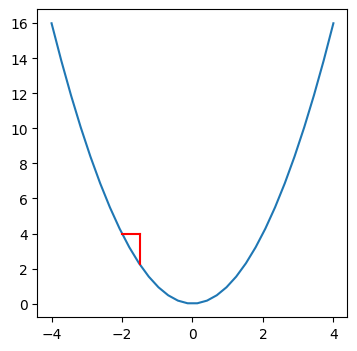

In [11]:
plot_roc(-2, 0.5)

The rate of change for different values of h are different at the same point x. We would like to come up with a single value that would tell how significantly y changes at a given point x within the function (`a` in the formula corresponds to `x` in the code).

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3)

Simply, this limit tells us how much the value of y will change when we change x by just a very small amount. Note: Essentially, [derivative is a function](https://math.stackexchange.com/questions/4837307/is-the-derivative-of-a-function-a-value-or-is-it-the-derivative-function-of-that#:~:text=The%20derivative%20of%20a%20function%20is%20a%20function%20(say%20d,xex%3Dex.).

In [12]:
x = 3
h = 0.000001 # limit of h approaches 0
d = (f(x + h) - f(x)) / h
print(f"The value of derivative function is {d}")

The value of derivative function is 6.000001000927568


## Partial Derivatives

Partial derivative with respect to some variable basically means how much the output will change when we nudge that variable by a very small amount.


### Addition

In [13]:
f = lambda x, y: x + y

In [14]:
x = 2
y = 3

f(x, y)

5

In [15]:
h = 0.000001
f(x + h, y)

5.000001

Let’s see partial derivatives with respect to x an y.

In [16]:
# wrt x
(f(x + h, y) - f(x, y)) / h

1.000000000139778

In [17]:
# wrt y
(f(x, y+h) - f(x, y)) / h

1.000000000139778

It will always approach 1 for addition, no matter what are the input values.

In [18]:
for x, y in zip([-20, 2, 3], [300, 75, 10]):
  print(f'x={x}, y={y}: {(f(x + h, y) - f(x, y)) / h}')

x=-20, y=300: 0.9999999974752427
x=2, y=75: 0.9999999974752427
x=3, y=10: 1.0000000010279564


Indeed, if we have simple addition x + y, then increasing x or y by some amount will increase the result by the exact same amount. Assertion will work for any number h gets.

In [19]:
h = 10
assert f(x+h, y) - f(x, y) == h
assert f(x, y+h) - f(x, y) == h

### Multiplication

In [20]:
f = lambda x, y: x * y

In [21]:
x = 2
y = 3
h = 1e-5 # same as 0.00001
(f(x + h, y) - f(x, y)) / h # wrt x

3.000000000064062

In [22]:
for x in [-20, 2, 3]:
  print(f'x={x}, y={y}: {(f(x + h, y) - f(x, y)) / h}')

x=-20, y=3: 2.999999999531155
x=2, y=3: 3.000000000064062
x=3, y=3: 3.000000000064062


In [23]:
x = 10
h = 5
pdx = (f(x+h, y) - f(x, y)) / h
print(pdx, y)
assert round(pdx, 2) == round(y, 2)

3.0 3


### Complex

In [24]:
def f(a, b, c):
  return a**2 + b**3 - c

In [25]:
a = 2
b = 3
c = 4

f(a, b, c)

27

In [26]:
h = 1

f(a + h, b, c)

32

In [27]:
f(a + h, b, c) - f(a, b, c)

5

In [28]:
(f(a + h, b, c) - f(a, b, c)) / h

5.0

In [29]:
h = 0.00001 # when the change is approaching zero
pda = (f(a + h, b, c) - f(a, b, c)) / h
pda

4.000010000027032

In [30]:
assert 2*a == round(pda)

Our function was <code>f(a,b,c) = a<sup>2</sup>+b<sup>3</sup>-c</code>. Partial derivative with respect to a is `2a` (by the power rule), and when `a=2` indeed we get 4.

**Exercise:** Code the partial derivative with respect to b and c and verify if the result correct.

## Micrograd and Computation Graph
Based on Karpathy's https://github.com/karpathy/micrograd

In [31]:
# This is a graph visualization code from micrograd, no need to understand the details
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.3f | grad %.3f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [32]:
# Value class stores a number and "remembers" information about its origins
class Value:
  def __init__(self, data, _prev=(), _op='', label=''):
    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self.grad = 0

  def __add__(self, other):
    data = self.data + other.data
    out = Value(data, (self, other), '+')
    return out

  def __mul__(self, other):
    data = self.data * other.data
    out = Value(data, (self, other), "*")
    return out

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

In [33]:
a = Value(5, label='a')
b = Value(3, label='b')
c = a + b; c.label = 'c'
d = Value(10, label='d')
L = c * d; L.label = 'L'

In [34]:
print(a, a._prev)
print(L, L._prev)

Value(data=5, grad=0) ()
Value(data=80, grad=0) (Value(data=8, grad=0), Value(data=10, grad=0))


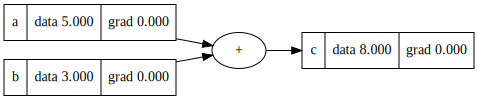

In [35]:
draw_dot(c)

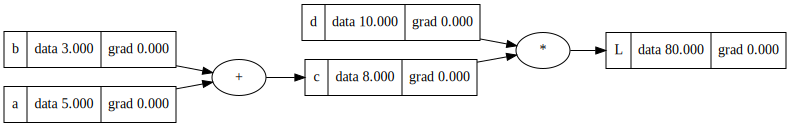

In [36]:
draw_dot(L)

## Gradient

Gradient is vector of [partial derivatives](https://stats.stackexchange.com/questions/285670/gradient-versus-partial-derivatives).

We want to know how much changing each variable will affect the output of `L`. We will store those partial derivatives inside each `grad` variable of each `Value` object.

In [37]:
L.grad = 1.0

The derivative of a variable with respect to itself is 1 (you get the same dx/dy).

In [38]:
f = lambda x: x
h = 1e-5
pdx = (f(x + h) - f(x)) / h
assert round(pdx) == 1

Now let's see how changing other variables will affect the eventual result.

In [39]:
def f(ha=0, hb=0, hc=0, hd=0):
  # same function as before
  a = Value(5 + ha, label='a')
  b = Value(3 + hb, label='b')
  c = a + b + Value(hc); c.label = 'c'
  d = Value(10 + hd, label='d')
  L = c * d; L.label = 'L'
  return L.data

In [40]:
h = 1e-5
(f(hd=h) - f()) / h

7.999999999697137

From the computational graph we can also see that `L=c*d`. When we change the value of d just a little bit (derivative of `L` with respect to `d`) the value of `L` will change by the amount of `c`, which is `8.0`. We saw it above in the partial derivative of a multiplication.

In [41]:
d.grad = c.data
c.grad = d.data

With the same logic, the derivative of `L` wrt `c` will be the value of `d`, which is `10.0`. We can verify it.

In [42]:
(f(hc=h) - f()) / h

10.000000000331966

## Chain Rule

To determine how much changing earlier variables in the computation graph will affect the `L` variable, we can apply the [chain rule](https://en.wikipedia.org/wiki/Chain_rule). Simply, the derivative of `L` with respect to `a` is the derivative of `c` with respect to `a` multiplied by the derivative of `L` with respect to `c`. God bless Leibniz.

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/e1a610aa8446be002e2e30d7121f6a87273d4caa)

The derivate of `c` both wrt `a` and 'b' is `1` due to the property of addition shown before (`c=a+b`). From here:

In [43]:
a.grad = 1.0 * c.grad
b.grad = 1.0 * c.grad

a.grad, b.grad

(10.0, 10.0)

We can verify it as well. Let's see how much `L` gets affected, when we shift `a` or `b` by a small amount.

In [44]:
(f(ha=h) - f()) / h

10.000000000331966

In [45]:
(f(hb=h) - f()) / h

10.000000000331966

We will finally redraw the manually updated computation graph.

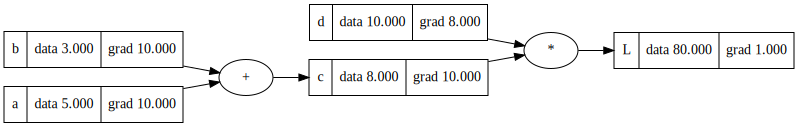

In [46]:
draw_dot(L)

It basically implies that, for example, changing the value of `a` by `1` unit (from 5 to 6) will increase the value of `L` by `10` units (from 80 to 90).

In [47]:
f(ha=1)

90

In [48]:
f(hb=1), f(hc=1), f(hd=1) # the rest of the cases

(90, 90, 88)

## Optimization with Gradient Descent

What we saw above was one backward pass done manually. We are mainly interested in the signs of partial derivatives to know if they are positively or negatively influencing the eventual loss `L` of our model. In our case, all the derivatives are positive and influence loss positively. 

We have to simply nudge the values in the opposite direction of the gradient to bring the loss down. This is known as [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).

In [49]:
lr = 0.01 # we will discuss learning rate later on

a.data -= lr * a.grad
b.data -= lr * b.grad
d.data -= lr * d.grad

# we skip c which is controlled by the values of a and b
# pay attention that the rest are leaf nodes in the computation graph

In case the loss is a negative value (not common), we will need to "gradient ascend" the loss upwards towards zero and change the sign to `+=` from `-=`. Note that the values of _parameters_ (a, b, d) can decrease or increase depending on the sign of `grad`.

## Forward Pass

We will now do a single forward pass to see if loss has been decreased. Previous loss was `80`.

In [50]:
# We will now forward pass
c = a + b
L = c * d

L.data

77.376

We optimized our values and brought down the loss.

## Backward Pass

Manually calculating gradient is good only for educational purposes. We should implement automatic backward pass which will calculate gradients. We will rewrite our `Value` class for `backward()` function.

In [51]:
class Value:
  def __init__(self, data, _prev=(), _op='', label=''):
    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None # initially it is a function which does nothing

  def __add__(self, other):
    data = self.data + other.data
    out = Value(data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    data = self.data * other.data
    out = Value(data, (self, other), "*")

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

In [52]:
# Recreating the same function
a = Value(5, label='a')
b = Value(3, label='b')
c = a + b; c.label = 'c'
d = Value(10, label='d')
L = c * d; L.label = 'L'

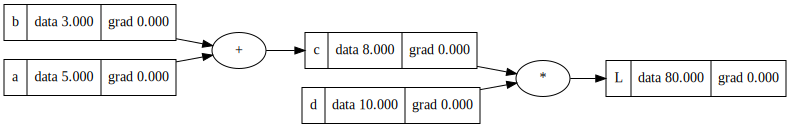

In [53]:
draw_dot(L)

We will initialize the gradient of the loss to be 1.0 and then call backward function. We should get the same results which we manually calculated previously.

In [54]:
L.grad = 1.0
L._backward()
c._backward()

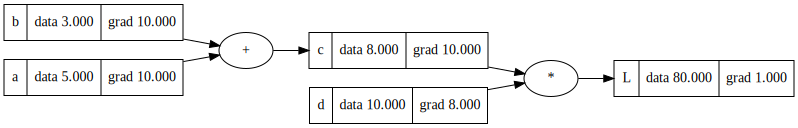

In [55]:
draw_dot(L)

**Exercise:** Make sure that all operations and their partial derivatives can be calculated (e.g. division, power).

# Training Model with Backpropagation

We can now call the optimization process, as well as forward and backward passes to reduce loss. Training model with the help of backward pass, optimization, and forward pass is called [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

In [56]:
# optimization
lr = 0.01
a.data -= lr * a.grad
b.data -= lr * b.grad
d.data -= lr * d.grad

# forward pass
c = a + b
L = c * d

# backward pass
L.grad = 1.0
L._backward()
c._backward()

L.data # loss

77.376

We have now trained the model for a single `epoch`. Even though what we do is oversimplistic and not precise, the main intuition and concepts behind training a neural network is the same.

We will train the model for multiple epochs until we reduce the loss down to zero.

In [57]:
while True:
  # optimization
  a.data -= lr * a.grad
  b.data -= lr * b.grad
  d.data -= lr * d.grad

  # forward pass
  c = a + b
  L = c * d

  # backward pass
  L.grad = 1.0
  L._backward()
  c._backward()

  if L.data < 0:
    break

  print(f'Loss: {round(L.data,2)}')

Loss: 74.81
Loss: 72.31
Loss: 69.87
Loss: 67.49
Loss: 65.16
Loss: 62.88
Loss: 60.66
Loss: 58.48
Loss: 56.35
Loss: 54.27
Loss: 52.23
Loss: 50.24
Loss: 48.28
Loss: 46.37
Loss: 44.49
Loss: 42.65
Loss: 40.84
Loss: 39.07
Loss: 37.33
Loss: 35.62
Loss: 33.94
Loss: 32.29
Loss: 30.66
Loss: 29.06
Loss: 27.48
Loss: 25.93
Loss: 24.39
Loss: 22.88
Loss: 21.39
Loss: 19.91
Loss: 18.45
Loss: 17.0
Loss: 15.57
Loss: 14.16
Loss: 12.75
Loss: 11.36
Loss: 9.97
Loss: 8.59
Loss: 7.22
Loss: 5.86
Loss: 4.5
Loss: 3.15
Loss: 1.8
Loss: 0.45


# PyTorch Implementation

All we did manually is built in to PyTorch. We will do a forward and backward pass and check if the gradients are what we had previosuly calculated. As gradients are not always calculated, for optimization purposes `requires_grad` is set to False by default. We cannot also calculate gradient for leaf nodes.

In [58]:
import torch

a = torch.tensor(5.0);    a.requires_grad = True
b = torch.tensor(3.0);    b.requires_grad = True
c = a + b
d = torch.tensor(10.0);   d.requires_grad = True
L = c * d

In [59]:
L.backward()

In [60]:
a.grad, b.grad, d.grad

(tensor(10.), tensor(10.), tensor(8.))

We got the expected result.